In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from hmmlearn import hmm
%matplotlib inline

In [2]:
# initial data cleaning
# file_path = "data/2015_Air_quality_in_northern_Taiwan.csv"
# df = pd.read_csv(file_path, parse_dates=["time"],index_col="time")
# df.iloc[:,1:] = df.iloc[:,1:].apply(lambda x: pd.to_numeric(x,errors='coerce'),axis=1).copy()
# df.to_csv("data/2015_removed_marked_data.csv", index=False)

# final data used
file_path = "data/2015_removed_marked_data.csv"
taipai = pd.read_csv(file_path)
taipai = taipai.fillna(method='ffill')
taipai.head()

,station,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PH_RAIN,...,RAINFALL,RAIN_COND,RH,SO2,THC,UVB,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,Banqiao,16.0,2.1,0.79,0.14,1.2,16.0,17.0,37.0,NaN,...,NaN,NaN,57.0,12.0,2.2,0.0,69.0,69.0,4.7,4.2
1,Banqiao,16.0,2.1,0.80,0.15,1.3,16.0,17.0,36.0,NaN,...,NaN,NaN,57.0,11.0,2.2,0.0,67.0,65.0,4.0,4.0
2,Banqiao,16.0,2.1,0.71,0.13,1.0,13.0,14.0,38.0,NaN,...,NaN,NaN,57.0,8.0,2.2,0.0,63.0,53.0,3.7,3.5
3,Banqiao,15.0,2.0,0.66,0.12,0.8,11.0,12.0,39.0,NaN,...,NaN,NaN,58.0,6.5,2.2,0.0,63.0,63.0,4.1,3.3
4,Banqiao,15.0,2.0,0.53,0.11,0.6,10.0,11.0,38.0,NaN,...,NaN,NaN,58.0,5.5,2.1,0.0,69.0,67.0,3.0,3.1


In [3]:
def bin_winds(col,n):
    cuts = np.linspace(0, 360, n + 1)
    col_binned = pd.cut(col, bins = cuts, labels = False)
    return col_binned

In [4]:
taipai['binned_wind'] = bin_winds(taipai.WIND_DIREC, 8)

# MARKOV MODELS!?!?!?! :D
Now we're going to move to one station and attempt to fit a nice little markov model...delicious

In [5]:
taipai.station.unique()

array(['Banqiao', 'Cailiao', 'Datong', 'Dayuan', 'Guanyin', 'Guting',
       'Keelung', 'Linkou', 'Longtan', 'Pingzhen', 'Sanchong', 'Shilin',
       'Songshan', 'Tamsui', 'Taoyuan', 'Tucheng', 'Wanhua', 'Wanli',
       'Xindian', 'Xinzhuang', 'Xizhi', 'Yangming', 'Yonghe', 'Zhongli',
       'Zhongshan'], dtype=object)

In [6]:
songshan = taipai.loc[taipai.station == "Songshan"]
songshan.columns

Index(['station', 'AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3',
       'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND', 'RH', 'SO2', 'THC',
       'UVB', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED', 'WS_HR', 'binned_wind'],
      dtype='object')

Subset to a smaller sample of the columns

In [7]:
sample_list = ["NO","SO2","O3","binned_wind"]
subset_songshan = songshan[sample_list]
subset_songshan.head()

,NO,SO2,O3,binned_wind
104952,2.0,12.0,34.0,1.0
104953,2.1,10.0,35.0,1.0
104954,1.8,8.4,38.0,1.0
104955,0.7,5.8,41.0,1.0
104956,0.7,4.9,42.0,1.0


Create the parameters for a markov model

In [8]:
def compute_wind_trans(bin_col):
    """
    Computes the transition matrix for the winds states; necessary for the MM
    
    Arguments
    ---------
    bin_col -- binned wind column; id as 0 indexed integers
    """
    # matrix of state transitions
    n = len(bin_col.unique())
    transition = np.ones((n,n))
    for i, j in zip(bin_col[:-1], bin_col[1:]):
        transition[int(i), int(j)] += 1

    # row normalize transition matrix
    row_sum = transition.sum(axis=1)

    return transition / row_sum[:, np.newaxis]

def compute_state_means(df, bin_col):
    """
    Compute an array of state means for each of the states; return a matrix of n states by m obserables
    """
    n, m = len(df[bin_col].unique()), df.shape[1] - 1
    mean_matrix = np.zeros((n,m))
    
    for s in np.sort(df[bin_col].unique()):
        mean_matrix[int(s),:] = df.loc[df[bin_col] == s, df.columns != bin_col].mean(axis=0)
        
    return mean_matrix

def split_train_test(df, p_train):
    """
    Splits our df into train test...scikit probably has this
    """
    i_test = int(df.shape[0] * p_train)
    train, test = df.iloc[:i_test,:], df.iloc[i_test:,:]
    return train, test

def compute_covar(df, bin_col):
    """
    Compute covariance matrices for each time
    """

# LETS TRAIN
First we shall split into training and test

In [9]:
train, test = split_train_test(subset_songshan, 0.5)

Now we'll use the train set to compute transition probabilities and compute state means

In [10]:
tran_mat = compute_wind_trans(train.binned_wind)
wind_means = compute_state_means(train, "binned_wind")

Now it's time to start the model

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\utils\depreca

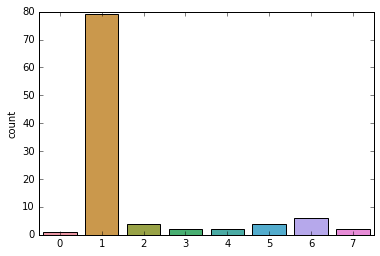

In [14]:
model = hmm.GaussianHMM(n_components = tran_mat.shape[0], covariance_type="full")
model.startprob_ = np.ones(tran_mat.shape[0]) / tran_mat.shape[0]
model.transmat_ = tran_mat
model.means_ = wind_means
model.covars_ = 0.5 * np.tile(np.identity(3), (8, 1, 1))
_, sseq = model.sample(100)
fig, axes = plt.subplots()
sb.countplot(sseq)

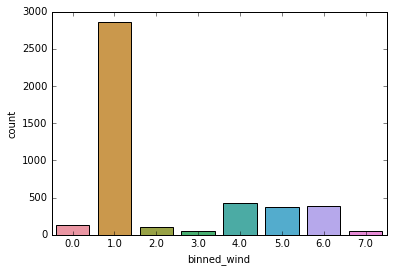

In [13]:
fig, axes = plt.subplots()
sb.countplot(train.binned_wind, ax=axes)